# Text Classification Using Manual Features and Traditional Machine Learning Models
In this example, we will classify words by manually extracting features from the words -- namely the first and last character of the word -- and then training a classifier using machine learning.

This example is based on [Chapter 6 of the NLTK book -- Learning to Classify Text](https://www.nltk.org/book/ch06.html).

In [1]:
import nltk
import sklearn
import random
import numpy as np
import matplotlib.pyplot as plt

# Fix the random seed for reproducibility
random.seed(0)
np.random.seed(0)

## Load the data
First, we will load the [Names corpus](https://www.kaggle.com/nltkdata/names) in NLTK. Then, we prepare the training data by tagging the names as male vs. female and shuffling the data.

In [2]:
# Load the data
from nltk.corpus import names
nltk.download("names") # Only need to run this once

# Annotate the data based on the text file they come from (male vs. female)
male_labeled_names = [(name, "male") for name in names.words("male.txt")]
female_labeled_names = [(name, "female") for name in names.words("female.txt")]
labeled_names = (male_labeled_names + female_labeled_names)

# Shuffle the data
random.shuffle(labeled_names)

num_male = len(male_labeled_names)
num_female = len(female_labeled_names)
num_total = num_male + num_female
print("Total number of names: {}\n({} male, {} female)".format(
    num_total, num_male, num_female))
print("\nSample names:")
for i in range(10):
    print(labeled_names[i])

Total number of names: 7944
(2943 male, 5001 female)

Sample names:
('Lissie', 'female')
('Danya', 'female')
('Welby', 'male')
('Antone', 'male')
('Bert', 'female')
('Erek', 'male')
('Gayleen', 'female')
('Rory', 'female')
('Donelle', 'female')
('Felicle', 'female')


[nltk_data] Downloading package names to /home/sebastian/nltk_data...
[nltk_data]   Package names is already up-to-date!


## Extract Features from the Text

These will be manually extracted features. We'll use the first and last letter of each name, but you should feel free to modify these and see if you can get better accuracy.

In [3]:
def gender_features(name):
    """ Extracts features from the word """
    features = {}
    features["first_letter"] = name[0].lower()
    features["last_letter"] = name[-1].lower()
    return features

labeled_features = [(gender_features(n), name) for (n, name) in labeled_names]

for i in range(10):
    print(labeled_features[i])

({'first_letter': 'l', 'last_letter': 'e'}, 'female')
({'first_letter': 'd', 'last_letter': 'a'}, 'female')
({'first_letter': 'w', 'last_letter': 'y'}, 'male')
({'first_letter': 'a', 'last_letter': 'e'}, 'male')
({'first_letter': 'b', 'last_letter': 't'}, 'female')
({'first_letter': 'e', 'last_letter': 'k'}, 'male')
({'first_letter': 'g', 'last_letter': 'n'}, 'female')
({'first_letter': 'r', 'last_letter': 'y'}, 'female')
({'first_letter': 'd', 'last_letter': 'e'}, 'female')
({'first_letter': 'f', 'last_letter': 'e'}, 'female')


## Encode the Features for a Statistical Classifier
The characters `a` through `z` need to be converted to a numeric representation before passing them into a classifier. Since there are only 26 characters, we can use a one-hot encoder to map the characters.

As you can see below, the one-hot encoded feature vector has dimension of 52 -- 26 for the first character and another 26 for the last character.

The labels are binary: we can simply encode them as 0 for male, 1 for female.

In [4]:
# Convert the features to one-hot vectors
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
X = [[f[key] for key in f] for (f, _) in labeled_features]
X_encoded = encoder.fit_transform(X)

# Labels are a binary output: 0 for male, 1 for female
y = np.array([0 if gnd=="male" else 1 for (_, gnd) in labeled_features])
names = [n for (n, _) in labeled_names]

print("Encoded one-hot features")
print(X_encoded)
print("Shape: {}".format(X_encoded.shape))
print("")
print("Binary classification labels")
print(y)
print("Shape: {}".format(y.shape))

Encoded one-hot features
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape: (7944, 52)

Binary classification labels
[1 1 0 ... 1 1 1]
Shape: (7944,)


## Create, Train, and Evaluate a Naive Bayes Classifier
Once have the data converted to numeric feature vectors and binary labels, we can use them in a classifier. 

For this example, we will use a [Naive Bayes classifier from scikit-learn](https://scikit-learn.org/stable/modules/naive_bayes.html) -- specifically the [categorical Naive Bayes classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html).

In [5]:
# Split the data into training and test sets. 
# Remember that the data was already shuffled, so we can just pick a cutoff index 
# where everything before is training data and everything after is test data.
cutoff_idx = 5000
X_train = X_encoded[:cutoff_idx]
y_train = y[:cutoff_idx]
names_train = names[:cutoff_idx]
X_test  = X_encoded[cutoff_idx:]
y_test  = y[cutoff_idx:]
names_test  = names[cutoff_idx:]

# Create and train a Categorical Naive Bayes classifier model
from sklearn.naive_bayes import CategoricalNB
use_prior = True
model = CategoricalNB()
model.fit(X_train, y_train)

# Predict on the training and test sets
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

## Evaluate the Model

Below we will examine the training and test accuracy and plot the confusion matrix. 

The results show that more male names are misclassified as female names than the opposite; this is because there are more female samples than male samples in the training set. Further steps need to be taken to deal with this class imbalance.

Training Accuracy: 3908/5000 = 78.16%
Test Accuracy: 2266/2944 = 76.97%


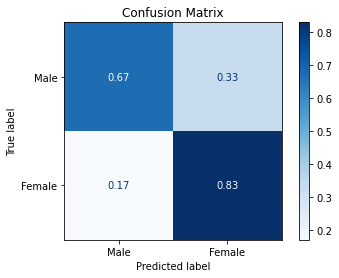


Example predictions
Name: Kimmi	Actual: female	Predicted: female
Name: Gustie	Actual: female	Predicted: female
Name: Wolf	Actual: male	Predicted: male
Name: Gardener	Actual: male	Predicted: male
Name: Chiarra	Actual: female	Predicted: female
Name: Verne	Actual: male	Predicted: female
Name: Kimberly	Actual: female	Predicted: female
Name: Aleta	Actual: female	Predicted: female
Name: Jenna	Actual: female	Predicted: female
Name: Damian	Actual: male	Predicted: male


In [6]:
# Calculate accuracy
num_train = len(y_train)
num_correct_train = np.sum(y_train == y_pred_train) 
train_acc =  100 * num_correct_train / num_train
print("Training Accuracy: {}/{} = {:.2f}%".format(
    num_correct_train, num_train, train_acc))
num_test = len(y_test)
num_correct_test = np.sum(y_test == y_pred_test) 
test_acc = 100 * num_correct_test / num_test
print("Test Accuracy: {}/{} = {:.2f}%".format(
    num_correct_test, num_test, test_acc))

# Plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=["Male","Female"],
                             cmap=plt.cm.Blues,
                             normalize="true")
disp.ax_.set_title("Confusion Matrix")
plt.show()

# Print a few examples
print("\nExample predictions")
for i in np.random.randint(len(y_test), size=10):
    actual = "male" if y_test[i]==0 else "female"
    pred = "male" if y_pred_test[i]==0 else "female" 
    print("Name: {}\tActual: {}\tPredicted: {}".format(
        names_test[i], actual, pred))